# (4주차) 10월5일
> 신경망의 표현력 

- toc:true
- branch: master
- badges: true
- comments: true
- author: 윤도현

In [308]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 

In [309]:
import graphviz

In [310]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

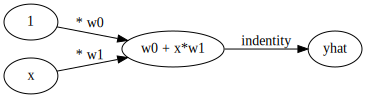

In [311]:
#collapse
gv(''' 
    "1" -> "w0 + x*w1"[label="* w0"]
    "x" -> "w0 + x*w1" [label="* w1"]
    "w0 + x*w1" -> "yhat"[label="indentity"]
    ''')

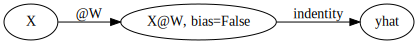

In [312]:
#collapse
gv('''
"X" -> "X@W, bias=False"[label="@W"] ;
"X@W, bias=False" -> "yhat"[label="indentity"] ''')

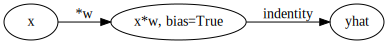

In [313]:
#collapse
gv('''
"x" -> "x*w, bias=True"[label="*w"] ;
"x*w, bias=True" -> "yhat"[label="indentity"] ''')

### 예제2 : polynomial regression

In [314]:
$y_i=w_0+w_1x_i + w_2 x_i^2 + w_3 x_i^3 +\epsilon_i$

SyntaxError: invalid syntax (Temp/ipykernel_3652/1397458478.py, line 1)

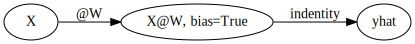

In [315]:
#collapse
gv('''
"X" -> "X@W, bias=True"[label="@W"]
"X@W, bias=True" -> "yhat"[label="indentity"] ''')

- ${\bf X} = \begin{bmatrix} 
x_1 & x_1^2 & x_1^3 \\ 
x_2 & x_2^2 & x_2^3 \\ 
\dots & \dots & \dots \\ 
x_n & x_n^2 & x_n^3 \\ 
\end{bmatrix}, \quad {\bf W} = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 
\end{bmatrix}$.

#### 시뮬레이션 연습

`-` 모형

In [326]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
X=torch.vstack([x,x**2,x**3]).T
W=torch.tensor([[4.0],[3.0],[-2.0]])
bias=1.0 
ϵ=torch.randn(100,1)
y=X@W+bias + ϵ

In [327]:
y.shape

torch.Size([100, 1])

In [328]:
X.shape

torch.Size([100, 3])

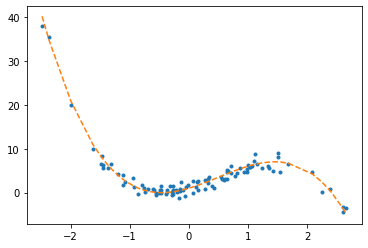

In [329]:
plt.plot(X[:,0],y,'.')
plt.plot(X[:,0],X@W+bias,'--')

`-` 아키텍처

In [330]:
net= torch.nn.Linear(in_features=3, out_features=1, bias=True)

`-` 손실함수

In [331]:
loss_fn=torch.nn.MSELoss()

`-` 미분

`-` 옵티마이저

In [332]:
optimizer=torch.optim.SGD(net.parameters(),lr=0.1)

`-` step 1~4 반복

In [333]:
for epoc in range(1000):
    ##step1
    yhat=net(X)
    ##step2
    loss=loss_fn(y,yhat)
    ##step3
    loss.backward()
    ##step4
    optimizer.step()
    net.zero_grad()

In [334]:
list(net.parameters())

[Parameter containing:
 tensor([[nan, nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([nan], requires_grad=True)]

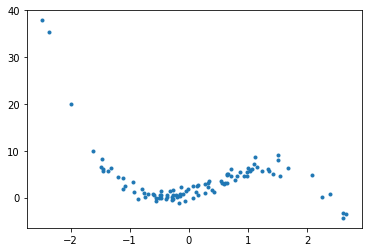

In [335]:
plt.plot(X[:,0],y,'.')
plt.plot(X[:,0],yhat.data,'--')

- 위와같은 결과가 나온 이유는 learning rate가 너무 커서 overshooting 문제가 발생하여 최솟값을 찾지못했기 때문입니다.

### 예제3: piece-wise linear regression

`-` 모델

In [303]:
_x = np.linspace(-1,1,100).tolist()
_f = lambda x: x*1+np.random.normal()*0.3 if x<0 else x*3.5 +np.random.normal()*0.3
_y= list(map(_f,_x))

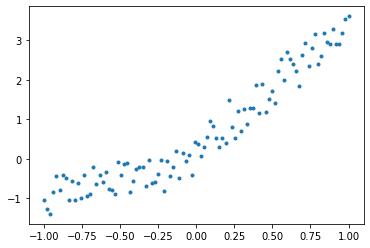

In [99]:
plt.plot(_x,_y,'.')

In [101]:
X= torch.tensor(_x).reshape(100,1)
y= torch.tensor(_y).reshape(100,1)

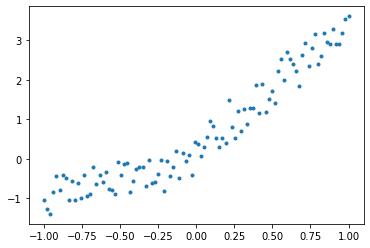

In [103]:
plt.plot(X,y,'.')

#### 풀이1

`-` 아키텍처 + 손실함수(mse) + 옵티마이저(SGD)

In [105]:
net=torch.nn.Linear(in_features=1, out_features=1, bias=True)
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.1)

`-` step 1~4 반복

In [106]:
for epoc in range(1000):
    yhat= net(X)
    loss= loss_fn(y,yhat)
    loss.backward()
    optimizer.step()
    net.zero_grad()

In [107]:
list(net.parameters())

[Parameter containing:
 tensor([[2.2339]], requires_grad=True),
 Parameter containing:
 tensor([0.6639], requires_grad=True)]

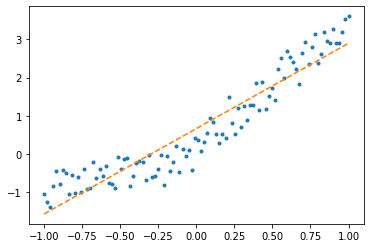

In [108]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` 실패: epoc를 10억번 돌려도 이건 실패할 것임
- 왜? 모델 자체가 틀려서 
- 모델의 표현력이 너무 부족하다 : underfitting

#### 풀이 2 : (비선형 활성화함수 적용)

`-` 비선형 활성화함수를 도입하자. (네트워크 수정)

In [173]:
torch.manual_seed(1)
layer1 = torch.nn.Linear(in_features=1, out_features=1, bias=False)
activation1 = torch.nn.ReLU()
net2 = torch.nn.Sequential(layer1, activation1)

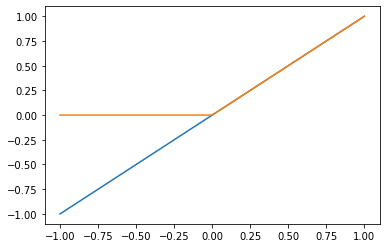

In [174]:
_x = np.linspace(-1,1,100)
plt.plot(_x,_x)
plt.plot(_x,activation1(torch.tensor(_x)))

`-` 표현력 확인

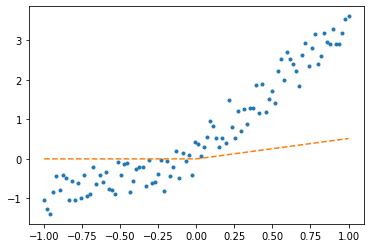

In [175]:
plt.plot(X,y,'.')
plt.plot(X,net2(X).data,'--')

`-` 옵티마이저2

In [176]:
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1)

In [177]:
for epoc in range(1000):
    yhat= net2(X)
    loss= loss_fn(y,yhat)
    loss.backward()
    optimizer2.step()
    net2.zero_grad()

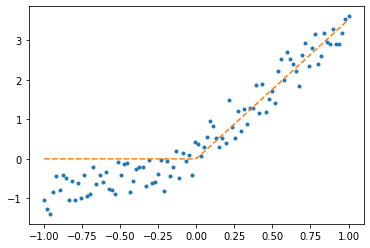

In [178]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` discussion 
- 이것 역시 수백억번 epoc를 반복해도 이 이상 적합하기 힘들다.
- 표현력이 여전히 부족하다.
- 해결책: 노드를 추가해보자!! 

#### 풀이3 : (노드수 추가)

In [183]:
torch.manual_seed(1)
layer1 = torch.nn.Linear(in_features=1, out_features=2, bias=False)
activation1 = torch.nn.ReLU()
layer2 = torch.nn.Linear(in_features=2, out_features=1, bias=False)
net3 = torch.nn.Sequential(layer1, activation1, layer2)
optimizer3 = torch.optim.SGD(net3.parameters(),lr=0.1)

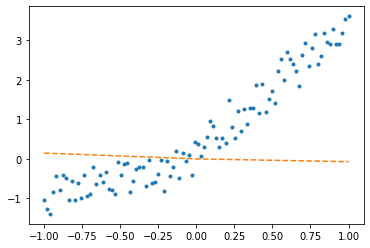

In [184]:
plt.plot(X,y,'.')
plt.plot(X,net3(X).data,'--')

In [185]:
for epoc in range(1000):
    yhat= net3(X)
    loss= loss_fn(y,yhat)
    loss.backward()
    optimizer3.step()
    net3.zero_grad()

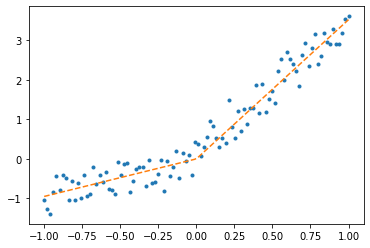

In [186]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

# 파라미터를 확인하는 방법!

In [191]:
W1=(layer1.weight.data).T
W2=(layer2.weight.data).T
W1,W2

(tensor([[ 1.9019, -0.9947]]),
 tensor([[ 1.8499],
         [-0.9546]]))

- 파라미터 저장

`-` 어떻게 적합이 이렇게 우수하게 되었는지 따져보자.

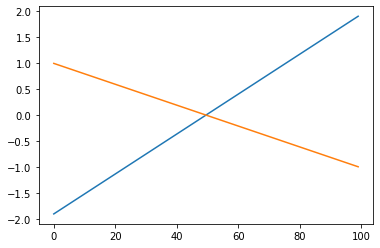

In [200]:
u1= X@W1
plt.plot(u1)
#plt.plot(X@W1)

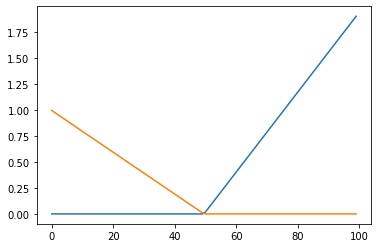

In [201]:
v1= activation1(u1)
plt.plot(v1)

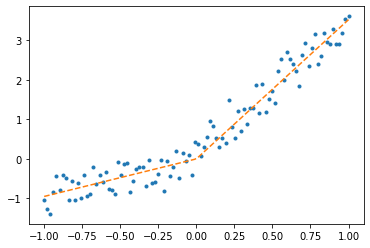

In [204]:
_yhat=v1@W2
plt.plot(X,y,'.')
plt.plot(X,_yhat,'--')
#plt.plot(X,activation1(X@W1)@W2,'--')

#### 요약(신경망)

`-` 계산과정

(1) $X \to X@W1^{(0)} \to ReLU(X@W1^{(1)}) \to ReLU(X@W1^{(1)})@W^{(2)} = yhat$

- $X: n \times 1$
- $W^{(0)}: 1 \times 2$
- $W^{(1)}: 2 \times 1$

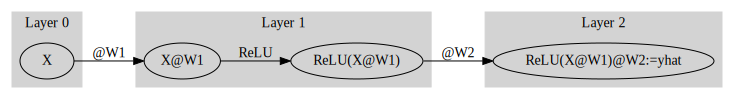

In [205]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "X@W1"[label="@W1"]
    "X@W1" -> "ReLU(X@W1)"[label="ReLU"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "ReLU(X@W1)" -> "ReLU(X@W1)@W2:=yhat"[label="@W2"]
    label = "Layer 2"
}
''')

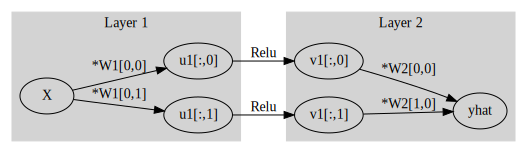

In [206]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"[label="*W1[0,0]"]
    "X" -> "u1[:,1]"[label="*W1[0,1]"]
    "u1[:,0]" -> "v1[:,0]"[label="Relu"]
    "u1[:,1]" -> "v1[:,1]"[label="Relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "yhat"[label="*W2[0,0]"]
    "v1[:,1]" -> "yhat"[label="*W2[1,0]"]
    label = "Layer 2"
}
''')

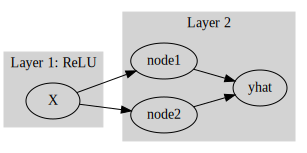

In [207]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat"
    "node2" -> "yhat"
    label = "Layer 2"
}
''')

#### 예제1 아키텍처 -1

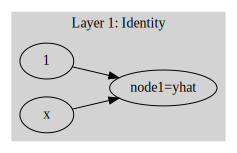

In [208]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "1" 
    "x" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "1" -> "node1=yhat"
    "x" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

#### 예제1 아키텍처 -2

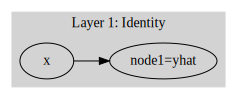

In [209]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

#### 예제 2 아키텍처

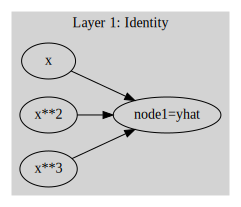

In [210]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x" 
    "x**2" 
    "x**3" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x" -> "node1=yhat"
    "x**2" -> "node1=yhat"
    "x**3" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

#### 풀이3이 실패할 수도 있음

`-` 아키텍처 + 옵티마이저

In [225]:
torch.manual_seed(40352) ## 초기가중치를 동일하게 
layer1 = torch.nn.Linear(in_features=1,out_features=2,bias=False) 
activation1 = torch.nn.ReLU() 
layer2 = torch.nn.Linear(in_features=2,out_features=1,bias=False) 
net3 = torch.nn.Sequential(layer1,activation1,layer2) 
optimizer3= torch.optim.SGD(net3.parameters(),lr=0.1)

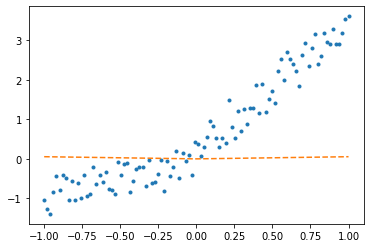

In [226]:
plt.plot(X,y,'.')
plt.plot(X,net3(X).data,'--')

In [227]:
for epoc in range(1000):
    yhat= net3(X)
    loss= loss_fn(y,yhat)
    loss.backward()
    optimizer3.step()
    net3.zero_grad()

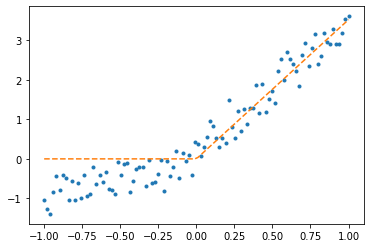

In [228]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

In [229]:
W1=(layer1.weight.data).T
W2=(layer2.weight.data).T
W1,W2

(tensor([[0.0021, 1.8374]]),
 tensor([[0.0722],
         [1.9148]]))

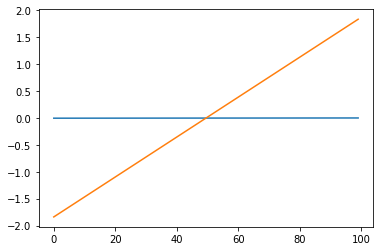

In [230]:
u1= X@W1
plt.plot(u1)
#plt.plot(X@W1)

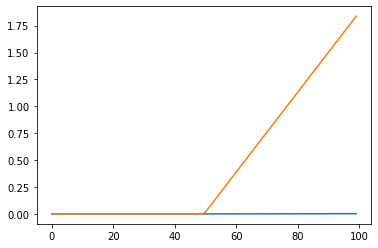

In [223]:
v1= activation1(u1)
plt.plot(v1)

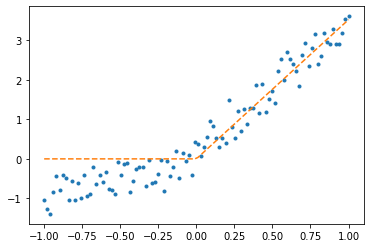

In [224]:
_yhat=v1@W2
plt.plot(X,y,'.')
plt.plot(X,_yhat,'--')
#plt.plot(X,activation1(X@W1)@W2,'--')

`-` 고약한 상황에 빠졌음

#### 풀이 4 : 넓은 신경망 = node가 많은 신경망

`-` Custom Activation Function

In [235]:
# simply define a mooyaho function
   
def mooyaho(input):
    return torch.sigmoid(200*input)
    
class MOOYAHO(torch.nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return mooyaho(input) # simply apply already implemented SiLU

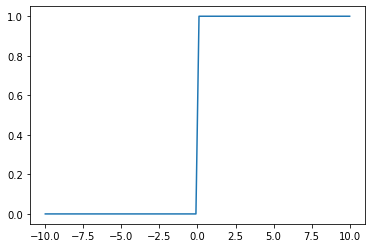

In [236]:
_x=torch.linspace(-10,10,100)
plt.plot(_x,mooyaho(_x))

`-` 아키텍처

In [237]:
torch.manual_seed(1) # 초기 가중치 똑같이 하기 위해
layer1= torch.nn.Linear(in_features=1, out_features=500, bias=True)
activation1= MOOYAHO()
layer2= torch.nn.Linear(in_features=500, out_features=1, bias=True)
net4= torch.nn.Sequential(layer1, activation1, layer2)
optimizer4= torch.optim.SGD(net4.parameters(),lr=0.001)

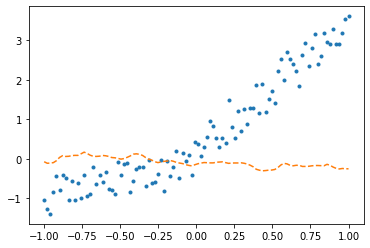

In [238]:
plt.plot(X,y,'.')
plt.plot(X,net4(X).data,'--')

In [239]:
for epoc in range(5000):
    yhat= net4(X)
    loss= loss_fn(y,yhat)
    loss.backward()
    optimizer4.step()
    net4.zero_grad()

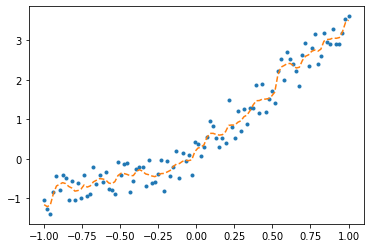

In [240]:
plt.plot(X,y,'.')
plt.plot(X,net4(X).data,'--')

`-` 넓은 신경망은 overfitting 하는 경우가 종종있다.

In [241]:
torch.manual_seed(43052)
__X= torch.linspace(-1,1,100).reshape(100,1)
__y= torch.randn(100,1)

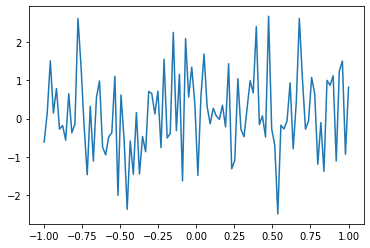

In [243]:
plt.plot(__X,__y)

In [248]:
torch.manual_seed(1) # 초기 가중치 똑같이 하기 위해
layer1= torch.nn.Linear(in_features=1, out_features=500, bias=True)
activation1= MOOYAHO()
layer2= torch.nn.Linear(in_features=500, out_features=1, bias=True)
net4= torch.nn.Sequential(layer1, activation1, layer2)
optimizer4= torch.optim.SGD(net4.parameters(),lr=0.001)

In [249]:
for epoc in range(5000):
    __yhat= net4(__X)
    loss= loss_fn(__yhat,__y)
    loss.backward()
    optimizer4.step()
    net4.zero_grad()

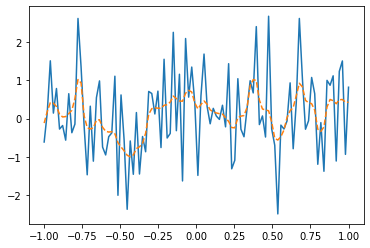

In [251]:
plt.plot(__X,__y)
plt.plot(__X,__yhat.data,'--')